In [3]:
import pandas as pd

# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 161 entries, Timestamp to Z_Intensity
dtypes: bool(1), float64(117), int64(23), object(20)
memory usage: 87.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 161 entries, Timestamp to Z_Intensity
dtypes: bool(1), float64(117), int64(23), object(20)
memory usage: 87.6+ MB


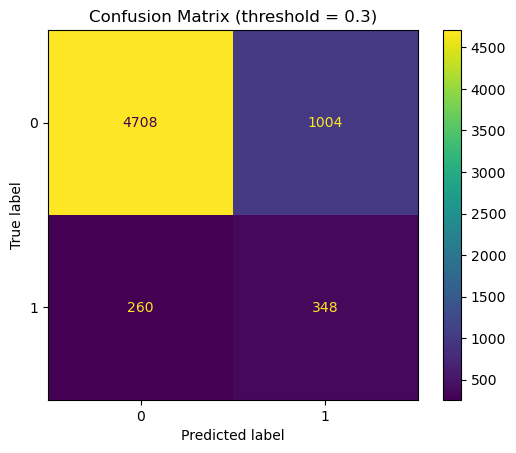

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9477    0.8242    0.8816      5712
           1     0.2574    0.5724    0.3551       608

    accuracy                         0.8000      6320
   macro avg     0.6025    0.6983    0.6184      6320
weighted avg     0.8813    0.8000    0.8310      6320

📈 Evaluation Metrics:
Accuracy:  0.8000
Precision: 0.2574
Recall:    0.5724
F1 Score:  0.3551
ROC AUC:   0.7924
PR AUC:    0.3210

🔍 Feature Importance (Top 15):
              Feature  Importance
57          Intensity    0.066632
55        Z_Intensity    0.042876
15  mean_intensity_1h    0.041693
44     1_1.5h_pre_std    0.033412
12           Time_24h    0.032642
13    hungry_weighted    0.026752
47     1.5_2h_pre_std    0.026059
14         EMA_T_Diff    0.025125
29         Sleep_Diff    0.024909
16  mean_intensity_2h    0.024882
1        15m_G_Diff_6    0.024792
17  mean_intensity_3h    0.024216
54               Z_HR    0.023685
45   1_1.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
    
]

# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))


In [7]:
# Count label occurrences in train set
print("📊 y_train class distribution:")
print(y_train.value_counts())

# Count label occurrences in test set
print("\n📊 y_test class distribution:")
print(y_test.value_counts())


📊 y_train class distribution:
GE_1h
0    22845
1    22845
Name: count, dtype: int64

📊 y_test class distribution:
GE_1h
0    5712
1     608
Name: count, dtype: int64


In [9]:
# Predict on training set
y_train_proba = model.predict_proba(X_train)[:, 1]
y_train_pred_thresh = (y_train_proba >= threshold).astype(int)

print("\n📋 Training Set Classification Report:")
print(classification_report(y_train, y_train_pred_thresh, digits=4))


📋 Training Set Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9999    0.9999     22845
           1     0.9999    1.0000    0.9999     22845

    accuracy                         0.9999     45690
   macro avg     0.9999    0.9999    0.9999     45690
weighted avg     0.9999    0.9999    0.9999     45690



# RandomizedSearchCV

# apply best search configuration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 161 entries, Timestamp to Z_Intensity
dtypes: bool(1), float64(117), int64(23), object(20)
memory usage: 87.6+ MB


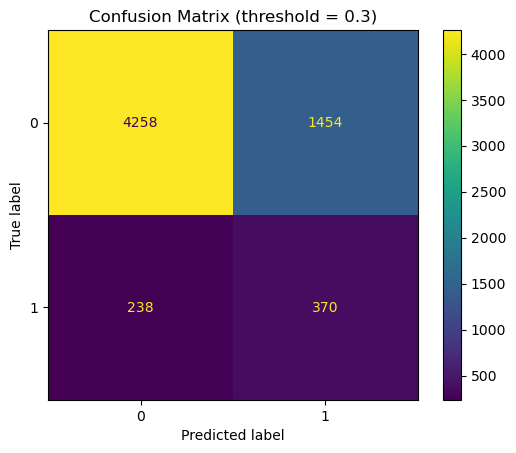

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9471    0.7454    0.8342      5712
           1     0.2029    0.6086    0.3043       608

    accuracy                         0.7323      6320
   macro avg     0.5750    0.6770    0.5693      6320
weighted avg     0.8755    0.7323    0.7833      6320

📈 Evaluation Metrics:
Accuracy:  0.7323
Precision: 0.2029
Recall:    0.6086
F1 Score:  0.3043
ROC AUC:   0.7437
PR AUC:    0.2170

🔍 Feature Importance (Top 15):
              Feature  Importance
57          Intensity    0.249474
15  mean_intensity_1h    0.159363
13    hungry_weighted    0.074448
44     1_1.5h_pre_std    0.049610
53       Z_Previous_4    0.039892
12           Time_24h    0.036149
2        15m_G_Diff_7    0.026183
0        15m_G_Diff_5    0.025466
50     2_2.5h_pre_std    0.022846
27          TimeInBed    0.018886
29         Sleep_Diff    0.018036
54               Z_HR    0.016585
4        15m_G_Diff_9    0.014779
47     1.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
    
]

# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model with best hyperparameters
model = RandomForestClassifier(
    n_estimators=1000,
    min_samples_split=50,
    min_samples_leaf=50,
    max_features=None,
    max_depth=50,
    criterion='entropy',
    class_weight=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1  # 병렬 처리
)
model.fit(X_train, y_train)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))



🔍 Feature Importance (Top 15):
              Feature  Importance
57          Intensity    0.249474
15  mean_intensity_1h    0.159363
13    hungry_weighted    0.074448
44     1_1.5h_pre_std    0.049610
53       Z_Previous_4    0.039892
12           Time_24h    0.036149
2        15m_G_Diff_7    0.026183
0        15m_G_Diff_5    0.025466
50     2_2.5h_pre_std    0.022846
27          TimeInBed    0.018886
29         Sleep_Diff    0.018036
54               Z_HR    0.016585
4        15m_G_Diff_9    0.014779
47     1.5_2h_pre_std    0.014373
1        15m_G_Diff_6    0.014217


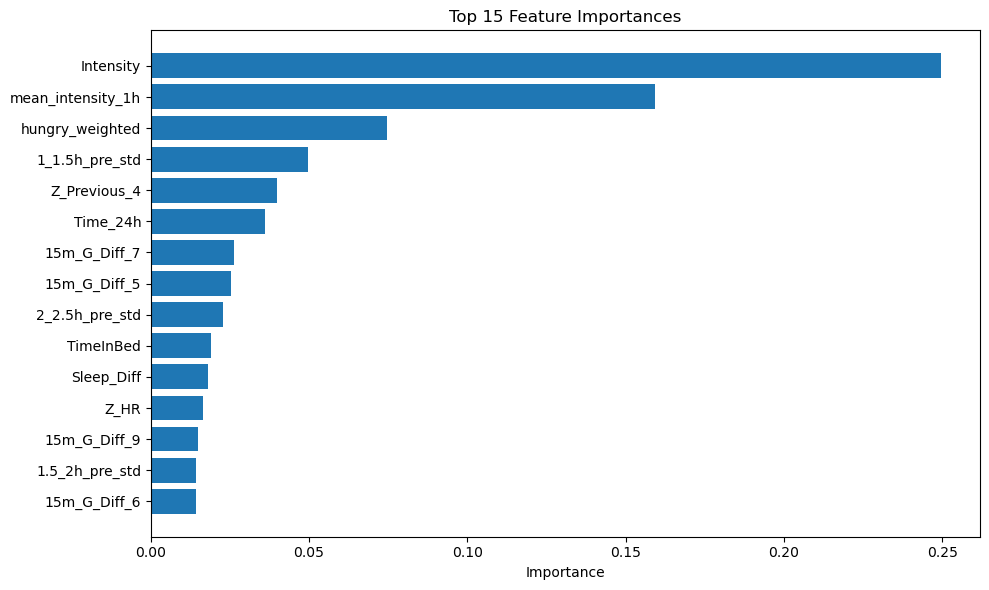

In [220]:
# RandomForestClassifier가 base_model로 래핑되어 있다고 가정
rf_model = best_model.base_model  # 또는 best_model.named_steps["base_model"]

importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))

# 시각화 (선택 사항)
plt.figure(figsize=(10, 6))
plt.barh(importances.head(15)["Feature"][::-1], importances.head(15)["Importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()



# F1-Threshold

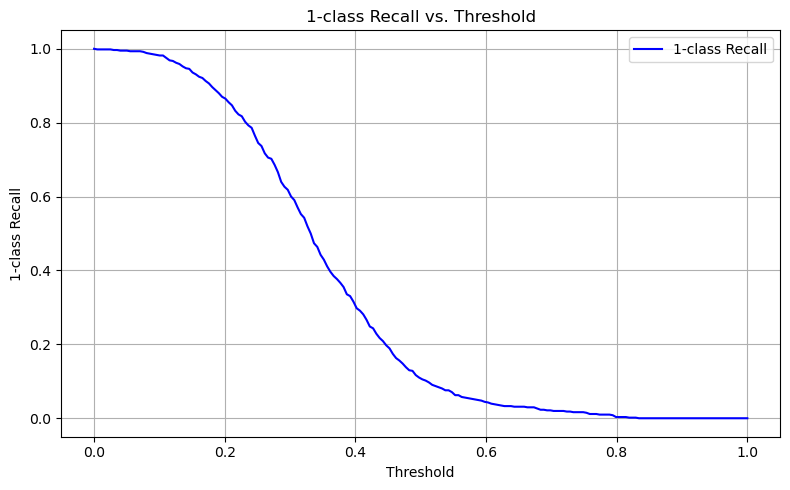

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# threshold sweep
thresholds = np.linspace(0, 1, 200)
recalls = [recall_score(y_test, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]

# plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label="1-class Recall", color="blue")
plt.xlabel("Threshold")
plt.ylabel("1-class Recall")
plt.title("1-class Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 최적 threshold (recall 최대)
best_idx = np.argmax(recalls)
best_threshold = thresholds[best_idx]
best_recall = recalls[best_idx]



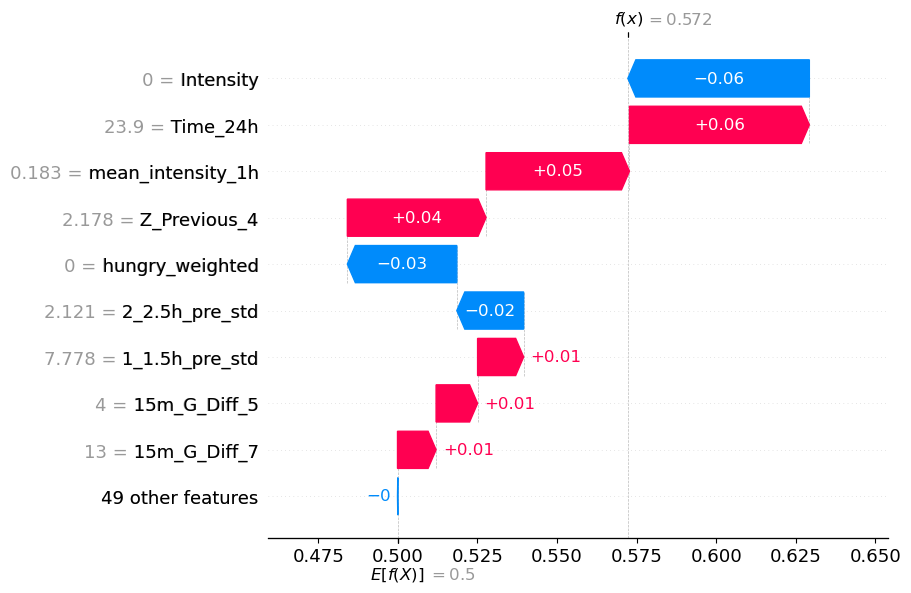

In [28]:
import shap

# SHAP explainer: RandomForestClassifier에 직접 적용
explainer = shap.TreeExplainer(model)

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[4]  # index 변경 가능
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot (class 1 기준으로)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],  # class 1의 shap 값
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )


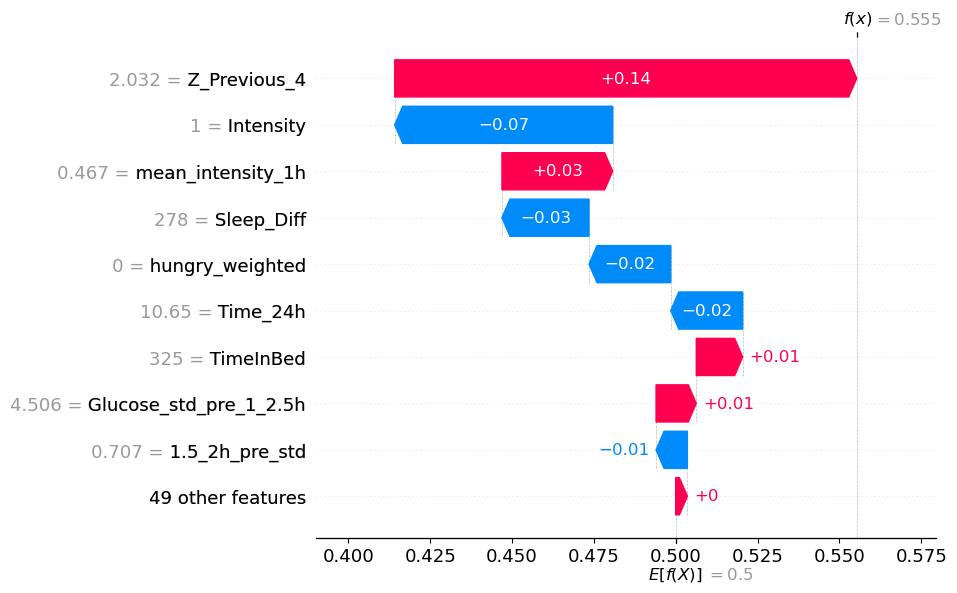

In [30]:
import shap

# SHAP explainer: RandomForestClassifier에 직접 적용
explainer = shap.TreeExplainer(model)

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[6]  # index 변경 가능
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot (class 1 기준으로)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],  # class 1의 shap 값
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )

In [238]:
intensity_counts = df['Intensity'].value_counts(dropna=False).sort_index()
intensity_counts

Intensity
0.0    57347
1.0    12450
2.0      745
3.0      768
NaN      407
Name: count, dtype: int64

In [240]:
ge_event_rate = df.groupby('Intensity')['GE_1h'].mean()
print(ge_event_rate)


Intensity
0.0    0.083836
1.0    0.126066
2.0    0.166667
3.0    0.154589
Name: GE_1h, dtype: object



📊 GE event 비율 (시간대별)
Time_hour_bin
0     0.059207
1     0.028851
2     0.026688
3     0.027778
4     0.018559
5     0.017525
6     0.032009
7     0.059544
8     0.077138
9     0.080157
10    0.092697
11    0.085214
12    0.156409
13    0.156682
14    0.138498
15    0.131737
16     0.11779
17     0.14075
18    0.157632
19    0.154232
20    0.163831
21     0.13952
22    0.126502
23    0.088608
Name: GE_1h, dtype: object


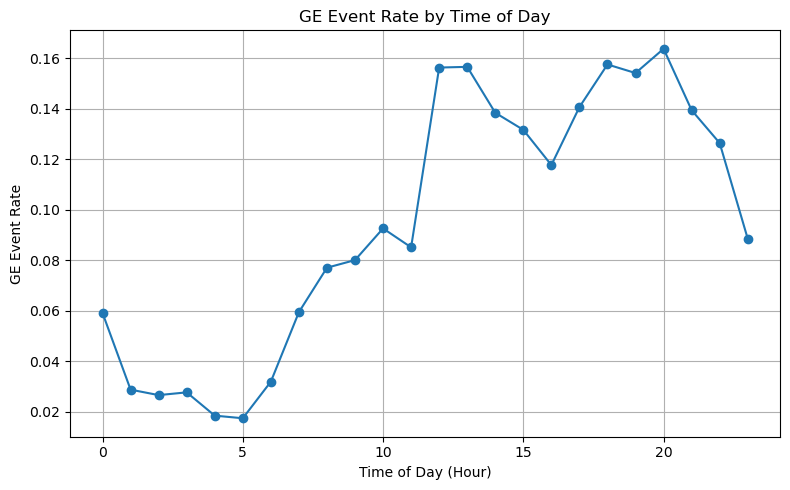

In [80]:
import pandas as pd

# Time_24h가 float 형태로 0~24 사이 값이라고 가정
# 1시간 단위로 bin 생성
df['Time_hour_bin'] = df['Time_24h'].apply(lambda x: int(x))

# 각 시간대 bin별 GE event 비율 계산
ge_rate_by_hour = df.groupby('Time_hour_bin')['GE_1h'].mean()

# 출력
print("\n📊 GE event 비율 (시간대별)")
print(ge_rate_by_hour)

# 시각화 (선택)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ge_rate_by_hour.index, ge_rate_by_hour.values, marker='o')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('GE Event Rate')
plt.title('GE Event Rate by Time of Day')
plt.grid(True)
plt.tight_layout()
plt.show()


# Validation

# add condition total rate

## Time 8-22, Exceed 2 time2

In [466]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 (시각화 조건 반영) -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)  # 1시간 이후 GE 발생 시점

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22
        ):
            alert_time = current_time
            # Success: alert 이후 2시간 이내에 GE 발생 여부 확인
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=120
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

# 정수 열 문자열로 변환 (소수점 제거)
cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

# 비율 포맷
for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

# Threshold 문자열로 변환
results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

# 리스트를 DataFrame으로 변환
results_with_sep = pd.DataFrame(results_with_sep)

# 출력 옵션 설정
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (visual logic: 2 consecutive, 2hr cooldown, 08–22h, 2hr GE detection):")
print(results_with_sep.to_string(index=False))

📊 Early Warning Evaluation (visual logic: 2 consecutive, 2hr cooldown, 08–22h, 2hr GE detection):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           47       17          13       0.764706              34 0.723404     0.276596
     0.20      40           48       29          21       0.724138              27 0.562500     0.437500
     0.20      59           42        9           8       0.888889              34 0.809524     0.190476
     0.20      86           47       25          16       0.640000              31 0.659574     0.340426
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           41       17          10       0.588235              31 0.756098     0.243902
     0.25      40           40       29          16       0.551724              24 0.600000     0.400000
     0.25      59           32        9           7       0.77

# Exceed Threshold 3 times

In [481]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 (rolling=3 적용) -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=3, min_periods=3).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(2, len(df)):  # 3개 rolling이므로 index 2부터 시작
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour

        if (
            rolling_sum >= 3 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22
        ):
            alert_time = current_time
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=120
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

# 출력
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("📊 Early Warning Evaluation (visual logic: 3 consecutive, 2hr cooldown, 08–22h, 2hr GE detection):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (visual logic: 3 consecutive, 2hr cooldown, 08–22h, 2hr GE detection):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           41       17           9       0.529412              32 0.780488     0.219512
     0.20      40           46       29          20       0.689655              26 0.565217     0.434783
     0.20      59           36        9           8       0.888889              28 0.777778     0.222222
     0.20      86           45       25          15       0.600000              30 0.666667     0.333333
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           33       17           8       0.470588              25 0.757576     0.242424
     0.25      40           32       29          17       0.586207              15 0.468750     0.531250
     0.25      59           26        9           7       0.77

# 3hrs + 4times 

In [495]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 (누적 위험 기반 조건 적용) -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120, window_minutes=180, min_hits=4):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)  # 1시간 이후 GE 발생 시점

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(len(df)):
        current_time = df.loc[i, "Timestamp"]
        hour = current_time.hour

        if current_time < last_alert_time + timedelta(minutes=cooldown_minutes):
            continue
        if not (8 <= hour < 22):
            continue

        # 윈도우 범위 내 초과 횟수 확인
        window_start = current_time - timedelta(minutes=window_minutes)
        hits = df[(df["Timestamp"] >= window_start) & (df["Timestamp"] <= current_time)]["Above_Threshold"].sum()

        if hits >= min_hits:
            success = any(current_time <= ge_time <= current_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": current_time, "Success": success})
            last_alert_time = current_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df,
            threshold=threshold,
            cooldown_minutes=120,
            window_minutes=180,  # 3시간
            min_hits=4           # 누적 3회 이상 초과
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

# 정수 열 문자열로 변환 (소수점 제거)
cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

# 비율 포맷
for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

# Threshold 문자열로 변환
results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

# 리스트를 DataFrame으로 변환
results_with_sep = pd.DataFrame(results_with_sep)

# 출력 옵션 설정
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (risk accumulation: ≥3 in 3h, 2hr cooldown, 08–22h, 2hr GE detection):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (risk accumulation: ≥3 in 3h, 2hr cooldown, 08–22h, 2hr GE detection):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           53       17          13       0.764706              40 0.754717     0.245283
     0.20      40           52       29          23       0.793103              29 0.557692     0.442308
     0.20      59           44        9           8       0.888889              36 0.818182     0.181818
     0.20      86           54       25          17       0.680000              37 0.685185     0.314815
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           44       17          11       0.647059              33 0.750000     0.250000
     0.25      40           43       29          18       0.620690              25 0.581395     0.418605
     0.25      59           36        9           8       0.88

# 30min, 2 times + 1hr mean > 1.4

In [504]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 (연속조건 + 누적 위험 스코어 조건 추가) -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120, risk_window_minutes=60, risk_sum_threshold=1.4):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)  # GE 발생 1시간 이후 시점

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour

        # 조건: 연속 2회 초과 + 쿨다운 + 시간 조건
        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22
        ):
            # 누적 위험 스코어 (이전 1시간의 Predicted_Proba 합)
            window_start = current_time - timedelta(minutes=risk_window_minutes)
            risk_window_mask = (df["Timestamp"] >= window_start) & (df["Timestamp"] <= current_time)
            risk_sum = df.loc[risk_window_mask, "Predicted_Proba"].sum()

            if risk_sum >= risk_sum_threshold:
                alert_time = current_time
                success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
                alerts.append({"Alert_Time": alert_time, "Success": success})
                last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df,
            threshold=threshold,
            cooldown_minutes=120,
            risk_window_minutes=60,
            risk_sum_threshold=1.4
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

# 정수 열 문자열로 변환 (소수점 제거)
cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

# 비율 포맷
for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

# Threshold 문자열로 변환
results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

# 리스트를 DataFrame으로 변환
results_with_sep = pd.DataFrame(results_with_sep)

# 출력 옵션 설정
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + 2hr cooldown + 08–22h + GE in 2hr):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + 2hr cooldown + 08–22h + GE in 2hr):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           34       17           8       0.470588              26 0.764706     0.235294
     0.20      40           30       29          12       0.413793              18 0.600000     0.400000
     0.20      59           27        9           8       0.888889              19 0.703704     0.296296
     0.20      86           31       25          13       0.520000              18 0.580645     0.419355
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           34       17           7       0.411765              27 0.794118     0.205882
     0.25      40           27       29          10       0.344828              17 0.629630     0.370370
     0.25      59           25        9           7       0.777778  

# 30min, 2 times + 1hr mean > 1.4 , Z_intensity, Z_HR < -0.2

In [508]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120, risk_window_minutes=60, risk_sum_threshold=1.4, z_cutoff=-0.2):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22
        ):
            # 누적 위험 스코어 (이전 1시간 합산)
            window_start = current_time - timedelta(minutes=risk_window_minutes)
            mask = (df["Timestamp"] >= window_start) & (df["Timestamp"] <= current_time)
            risk_sum = df.loc[mask, "Predicted_Proba"].sum()
            
            # Z조건
            z_hr = df.loc[i, "Z_HR"]
            z_intensity = df.loc[i, "Z_Intensity"]

            if risk_sum >= risk_sum_threshold and z_hr < z_cutoff and z_intensity < z_cutoff:
                alert_time = current_time
                success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
                alerts.append({"Alert_Time": alert_time, "Success": success})
                last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df,
            threshold=threshold,
            cooldown_minutes=120,
            risk_window_minutes=60,
            risk_sum_threshold=1.4,
            z_cutoff=-0.2
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + Z_HR & Z_Intensity < -0.2 + cooldown + 08–22h):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + Z_HR & Z_Intensity < -0.2 + cooldown + 08–22h):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           24       17           5       0.294118              19 0.791667     0.208333
     0.20      40           20       29           8       0.275862              12 0.600000     0.400000
     0.20      59            6        9           1       0.111111               5 0.833333     0.166667
     0.20      86           20       25           9       0.360000              11 0.550000     0.450000
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           20       17           5       0.294118              15 0.750000     0.250000
     0.25      40           17       29           7       0.241379              10 0.588235     0.411765
     0.25      59            6        9           1     

In [520]:
# Intensity or HR

In [522]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120, risk_window_minutes=60, risk_sum_threshold=1.4):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22
        ):
            # 누적 위험 점수
            window_start = current_time - timedelta(minutes=risk_window_minutes)
            risk_window_mask = (df["Timestamp"] >= window_start) & (df["Timestamp"] <= current_time)
            risk_sum = df.loc[risk_window_mask, "Predicted_Proba"].sum()

            # Z_HR 또는 Z_Intensity 조건 (or)
            z_hr = df.loc[i, "Z_HR"]
            z_intensity = df.loc[i, "Z_Intensity"]
            if risk_sum >= risk_sum_threshold and (z_hr < -0.2 or z_intensity < -0.2):
                alert_time = current_time
                success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
                alerts.append({"Alert_Time": alert_time, "Success": success})
                last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df,
            threshold=threshold,
            cooldown_minutes=120,
            risk_window_minutes=60,
            risk_sum_threshold=1.4
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

# 출력
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + Z_HR or Z_Intensity < -0.2 + cooldown + time window):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + Z_HR or Z_Intensity < -0.2 + cooldown + time window):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           34       17           7       0.411765              27 0.794118     0.205882
     0.20      40           28       29           9       0.310345              19 0.678571     0.321429
     0.20      59           25        9           7       0.777778              18 0.720000     0.280000
     0.20      86           27       25          10       0.400000              17 0.629630     0.370370
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           33       17           8       0.470588              25 0.757576     0.242424
     0.25      40           23       29           8       0.275862              15 0.652174     0.347826
     0.25      59           22        9           

# Add Z_Previous 4

In [530]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120, risk_window_minutes=60, risk_sum_threshold=1.4):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22
        ):
            # 누적 risk score 계산
            window_start = current_time - timedelta(minutes=risk_window_minutes)
            risk_window_mask = (df["Timestamp"] >= window_start) & (df["Timestamp"] <= current_time)
            risk_sum = df.loc[risk_window_mask, "Predicted_Proba"].sum()

            z_hr = df.loc[i, "Z_HR"]
            z_intensity = df.loc[i, "Z_Intensity"]
            z_glucose = df.loc[i, "Z_Previous_4"]

            # 조건: 누적 위험 점수 + (Z_HR or Z_Intensity or Z_Previous_4)
            if risk_sum >= risk_sum_threshold and (
                z_hr < -0.2 or z_intensity < -0.2 or z_glucose >= 0.5
            ):
                alert_time = current_time
                success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
                alerts.append({"Alert_Time": alert_time, "Success": success})
                last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df,
            threshold=threshold,
            cooldown_minutes=120,
            risk_window_minutes=60,
            risk_sum_threshold=1.4
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)
cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("\n📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + Z_HR or Z_Intensity or Z_Glucose + cooldown + time window):")
print(results_with_sep.to_string(index=False))



📊 Early Warning Evaluation (30min 2x + 1hr risk ≥ 1.4 + Z_HR or Z_Intensity or Z_Glucose + cooldown + time window):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           34       17           7       0.411765              27 0.794118     0.205882
     0.20      40           29       29          10       0.344828              19 0.655172     0.344828
     0.20      59           26        9           8       0.888889              18 0.692308     0.307692
     0.20      86           29       25          12       0.480000              17 0.586207     0.413793
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           33       17           7       0.411765              26 0.787879     0.212121
     0.25      40           25       29           9       0.310345              16 0.640000     0.360000
     0.25      59           23        9    

# 30min 2times + Z_Previous 4 >0.1

In [533]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 (Z_Previous_4 조건 포함) -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)  # 1시간 이후 GE 발생 시점

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_glucose = df.loc[i, "Z_Previous_4"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_glucose >= 0.1
        ):
            alert_time = current_time
            # Success: alert 이후 2시간 이내에 GE 발생 여부 확인
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=120
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

# 정수 열 문자열로 변환 (소수점 제거)
cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

# 비율 포맷
for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

# Threshold 문자열로 변환
results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

# 리스트를 DataFrame으로 변환
results_with_sep = pd.DataFrame(results_with_sep)

# 출력 옵션 설정
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + cooldown + time window):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + cooldown + time window):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           29       17           8       0.470588              21 0.724138     0.275862
     0.20      40           37       29          14       0.482759              23 0.621622     0.378378
     0.20      59           28        9           7       0.777778              21 0.750000     0.250000
     0.20      86           35       25          13       0.520000              22 0.628571     0.371429
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           26       17           8       0.470588              18 0.692308     0.307692
     0.25      40           28       29          12       0.413793              16 0.571429     0.428571
     0.25      59           26        9           6       0.666667    

# 30min 2times +  pre4 G > rolling mean

In [579]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Previous_4_Glucose", "Rolling_Mean"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        pre_glucose = df.loc[i, "Previous_4_Glucose"]
        rolling_mean = df.loc[i, "Rolling_Mean"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            pre_glucose <= rolling_mean
        ):
            alert_time = current_time
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=120
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

# 정수 열 문자열로 변환 (소수점 제거)
cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

# 비율 포맷
for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

# Threshold 문자열로 변환
results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

# 리스트를 DataFrame으로 변환
results_with_sep = pd.DataFrame(results_with_sep)

# 출력 옵션 설정
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (2 consecutive + Previous_4_Glucose ≤ Rolling_Mean + cooldown + time window):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (2 consecutive + Previous_4_Glucose ≤ Rolling_Mean + cooldown + time window):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           30       17           8       0.470588              22 0.733333     0.266667
     0.20      40           30       29          14       0.482759              16 0.533333     0.466667
     0.20      59           27        9           5       0.555556              22 0.814815     0.185185
     0.20      86           27       25           6       0.240000              21 0.777778     0.222222
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           22       17           5       0.294118              17 0.772727     0.227273
     0.25      40           22       29           8       0.275862              14 0.636364     0.363636
     0.25      59           16        9           4    

# 30min 2times + Z_Previous 4 >0.1 + pre 4< 130mg/dl

In [595]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_glucose = df.loc[i, "Z_Previous_4"]
        pre4_glucose = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_glucose >= 0.1 and
            pre4_glucose < 130   # <- 추가된 조건: 발송 시점 혈당 130 이상이면 억제
        ):
            alert_time = current_time
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=120
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + cooldown + time window):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + cooldown + time window):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           29       17           8       0.470588              21 0.724138     0.275862
     0.20      40           36       29          14       0.482759              22 0.611111     0.388889
     0.20      59           28        9           7       0.777778              21 0.750000     0.250000
     0.20      86           35       25          13       0.520000              22 0.628571     0.371429
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           26       17           8       0.470588              18 0.692308     0.307692
     0.25      40           27       29          12       0.413793              15 0.555556     0.444444
     0.25      59           25        9          

# Cool down -> 2:30, 30min 2times + Z_Previous 4 >0.1 + pre 4 < 130mg/dl

In [591]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE", "Z_Previous_4", "Previous_4_Glucose"])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 (조건 포함) -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=150):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)  # 1시간 이후 GE 발생 시점

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        rolling_sum = df.loc[i, "Rolling_Sum"]
        hour = current_time.hour
        z_glucose = df.loc[i, "Z_Previous_4"]
        pre4_glucose = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_glucose >= 0.1 and
            pre4_glucose < 130
        ):
            alert_time = current_time
            # Success: alert 이후 2시간 이내에 GE 발생 여부 확인
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.3, 0.31, 0.1):  # 0.3만 테스트
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df,
            threshold=threshold,
            cooldown_minutes=150  # 2시간 30분
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

# 정수 열 문자열로 변환 (소수점 제거)
cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

# 비율 포맷
for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}" if pd.notnull(x) else "---")

# Threshold 문자열로 변환
results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

# 리스트를 DataFrame으로 변환
results_with_sep = pd.DataFrame(results_with_sep)

# 출력 옵션 설정
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Previous_4_Glucose < 130 + cooldown 150min + time window):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Previous_4_Glucose < 130 + cooldown 150min + time window):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.30       8           19       17           5       0.294118              14 0.736842     0.263158
     0.30      40           18       29           8       0.275862              10 0.555556     0.444444
     0.30      59           16        9           7       0.777778               9 0.562500     0.437500
     0.30      86           17       25           8       0.320000               9 0.529412     0.470588


# 2hrs cool down, 30min 2times + Z_Previous 4 >0.1 + pre 4 < 130mg/dl, pre4&5 < rolling mean

In [599]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ------------------- Holdout 참가자 설정 -------------------
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()

holdout_df = holdout_df.dropna(subset=X_columns + [
    "Onset_GE", "Z_Previous_4", "Previous_4_Glucose", "Previous_5_Glucose", "Rolling_Mean"
])
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
X_holdout = holdout_df[X_columns]
holdout_df["Predicted_Proba"] = model.predict_proba(X_holdout)[:, 1]

# ------------------- 평가 함수 -------------------
def evaluate_alerts_visual_logic(df, threshold, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()
    ge_times = df[df["Onset_GE"] == 1]["Timestamp"] + timedelta(minutes=60)

    alerts = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        row = df.loc[i]
        current_time = row["Timestamp"]
        rolling_sum = row["Rolling_Sum"]
        hour = current_time.hour

        z_glucose = row["Z_Previous_4"]
        pre4_glucose = row["Previous_4_Glucose"]
        pre5_glucose = row["Previous_5_Glucose"]
        rolling_mean = row["Rolling_Mean"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_glucose >= 0.1 and
            pre4_glucose < 130 and
            not (pre4_glucose > rolling_mean and pre5_glucose > rolling_mean)  # 메시지 억제 조건
        ):
            alert_time = current_time
            success = any(alert_time <= ge_time <= alert_time + timedelta(minutes=120) for ge_time in ge_times)
            alerts.append({"Alert_Time": alert_time, "Success": success})
            last_alert_time = alert_time

    alerts_df = pd.DataFrame(alerts)
    total_alerts = len(alerts_df)
    success_count = alerts_df["Success"].sum() if not alerts_df.empty else 0
    fp_count = total_alerts - success_count
    total_ge = len(ge_times)
    detection_rate = success_count / total_ge if total_ge > 0 else np.nan
    fp_rate = fp_count / total_alerts if total_alerts > 0 else np.nan
    success_rate = success_count / total_alerts if total_alerts > 0 else np.nan

    return total_alerts, success_count, total_ge, fp_count, success_rate, detection_rate, fp_rate

# ------------------- Threshold 루프 -------------------
results = []
for threshold in np.arange(0.2, 0.51, 0.05):
    for sid in holdout_df["StudyID"].unique():
        sub_df = holdout_df[holdout_df["StudyID"] == sid]
        total_alerts, success, total_ge, fp, success_rate, detection_rate, fp_rate = evaluate_alerts_visual_logic(
            sub_df, threshold=threshold, cooldown_minutes=120
        )
        results.append({
            "Threshold": round(threshold, 2),
            "StudyID": sid,
            "Total_Alerts": total_alerts,
            "Total_GE": total_ge,
            "Detected_GE": success,
            "Detection_Rate": detection_rate,
            "False_Positives": fp,
            "FP_Rate": fp_rate,
            "Success_Rate": success_rate
        })

# ------------------- 출력용 데이터프레임 구성 -------------------
results_df = pd.DataFrame(results)

cols_to_int = ["StudyID", "Total_Alerts", "Total_GE", "Detected_GE", "False_Positives"]
for col in cols_to_int:
    results_df[col] = results_df[col].astype(int).astype(str)

for col in ["Detection_Rate", "FP_Rate", "Success_Rate"]:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.6f}")

results_df["Threshold"] = results_df["Threshold"].apply(lambda x: f"{x:.2f}")

# 구분선 삽입
results_with_sep = []
for i in range(len(results_df)):
    results_with_sep.append(results_df.iloc[i])
    if (i + 1) % 4 == 0 and i != len(results_df) - 1:
        results_with_sep.append(pd.Series({
            "Threshold": "---", "StudyID": "---", "Total_Alerts": "---",
            "Total_GE": "---", "Detected_GE": "---",
            "Detection_Rate": "---", "False_Positives": "---",
            "FP_Rate": "---", "Success_Rate": "---"
        }))

results_with_sep = pd.DataFrame(results_with_sep)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# 결과 출력
print("📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + Pre4&5 > Rolling_Mean 억제 + cooldown + time window):")
print(results_with_sep.to_string(index=False))


📊 Early Warning Evaluation (2 consecutive + Z_Previous_4 ≥ 0.1 + Pre4_Glucose < 130 + Pre4&5 > Rolling_Mean 억제 + cooldown + time window):
Threshold StudyID Total_Alerts Total_GE Detected_GE Detection_Rate False_Positives  FP_Rate Success_Rate
     0.20       8           12       17           4       0.235294               8 0.666667     0.333333
     0.20      40           19       29           8       0.275862              11 0.578947     0.421053
     0.20      59           11        9           3       0.333333               8 0.727273     0.272727
     0.20      86           12       25           3       0.120000               9 0.750000     0.250000
      ---     ---          ---      ---         ---            ---             ---      ---          ---
     0.25       8           11       17           4       0.235294               7 0.636364     0.363636
     0.25      40           13       29           5       0.172414               8 0.615385     0.384615
     0.25      59     

# Visualization, 59, onset ge

# New Condition
## 30min 2 times + Z_pre 4 >0.1 + pre4 <130mg/dl


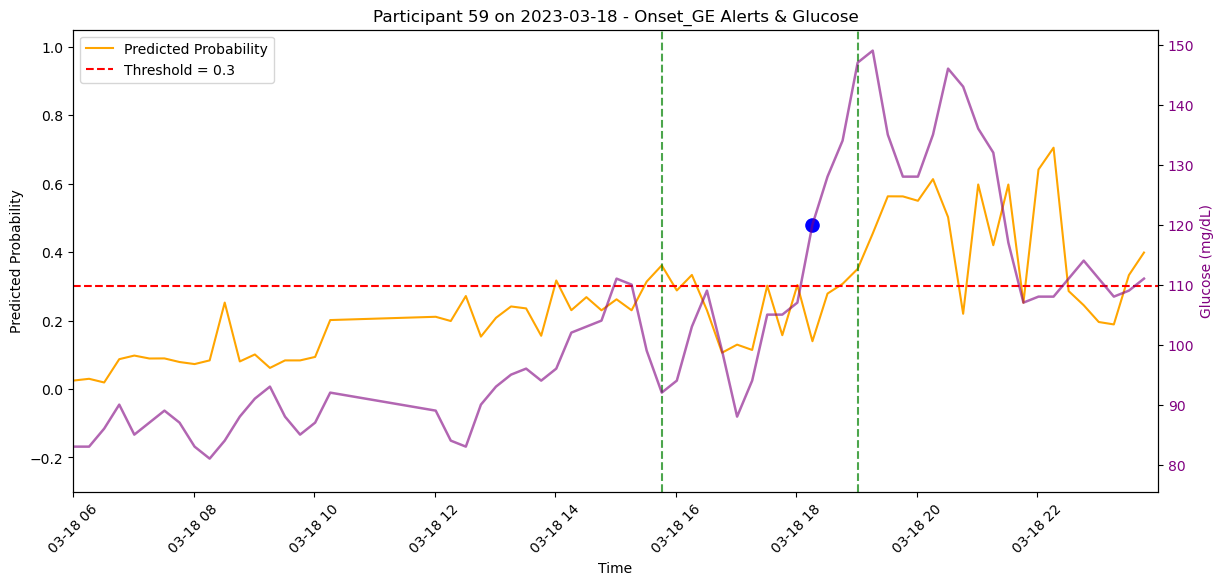

📋 Alert Summary:
           Alert_Time  Success    FP
0 2023-03-18 15:46:00    False  True
1 2023-03-18 19:01:00    False  True

✅ Total Alerts: 2
🏆 Success (Onset_GE within 2hr): 0
❌ FP (Message Sent, No GE): 2


In [636]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 수정된 알림 시점 계산 함수 (조건 추가)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        hour = current_time.hour
        rolling_sum = df.loc[i, "Rolling_Sum"]
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# 시각화 및 결과 요약 함수
def plot_alerts_with_success_only(df, study_id, date, threshold=0.3, cooldown_minutes=120):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)

    # Glucose 값 보간
    onset_df["Glucose_At_Onset"] = np.interp(
        onset_df["Shifted_Timestamp"].astype(np.int64),
        sub_df["Timestamp"].astype(np.int64),
        sub_df["Glucose"]
    )

    results = []
    success_count = 0
    fp_count = 0
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    for alert_time in alert_times:
        has_success = any(alert_time <= t <= alert_time + timedelta(minutes=120) for t in shifted_onset_times)
        results.append({
            "Alert_Time": alert_time,
            "Success": has_success,
            "FP": not has_success
        })
        if has_success:
            success_count += 1
        else:
            fp_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

        ax2.scatter(
            onset_df["Shifted_Timestamp"],
            onset_df["Glucose_At_Onset"],
            color="blue",
            s=90,
            label="GE Onset (+1hr)"
        )

    plt.title(f"Participant {study_id} on {date} - Onset_GE Alerts & Glucose")
    plt.show()

    # 결과 요약 출력
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🏆 Success (Onset_GE within 2hr): {success_count}")
    print(f"❌ FP (Message Sent, No GE): {fp_count}")

# 실행 예시
participant_id = 59
specific_date = pd.to_datetime("2023-03-18").date()  # 원하는 날짜로 수정

plot_alerts_with_success_only(holdout_df, participant_id, specific_date, threshold=0.3)


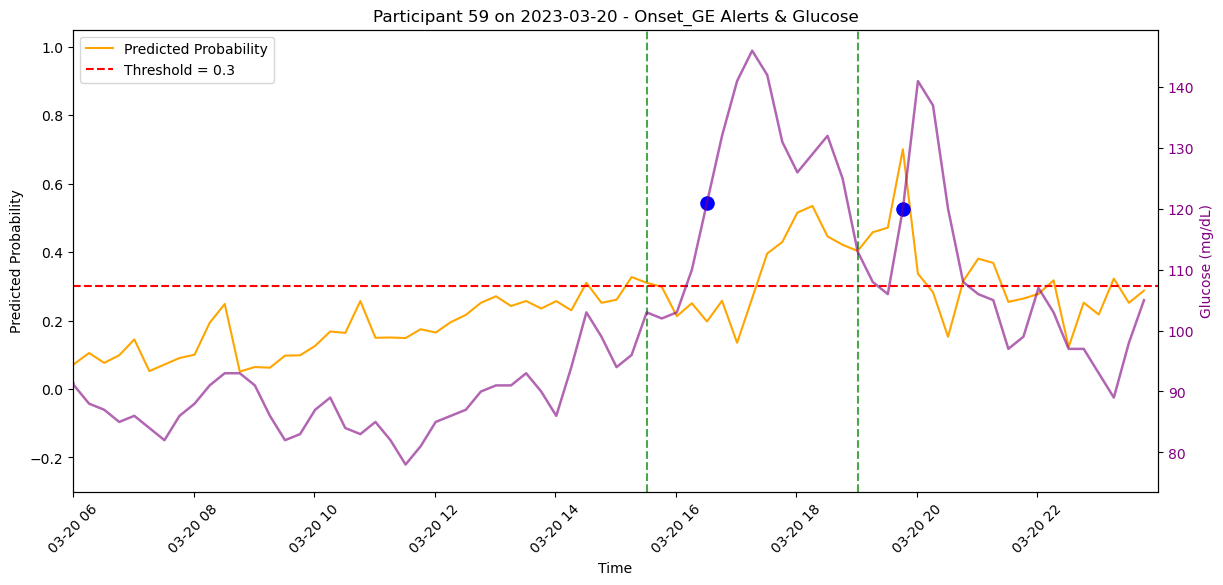

📋 Alert Summary:
           Alert_Time  Success     FP
0 2023-03-20 15:31:00     True  False
1 2023-03-20 19:01:00     True  False

✅ Total Alerts: 2
🏆 Success (Onset_GE within 2hr): 2
❌ FP (Message Sent, No GE): 0


In [642]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 수정된 알림 시점 계산 함수 (조건 추가)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        hour = current_time.hour
        rolling_sum = df.loc[i, "Rolling_Sum"]
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# 시각화 및 결과 요약 함수
def plot_alerts_with_success_only(df, study_id, date, threshold=0.3, cooldown_minutes=120):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)

    # Glucose 값 보간
    onset_df["Glucose_At_Onset"] = np.interp(
        onset_df["Shifted_Timestamp"].astype(np.int64),
        sub_df["Timestamp"].astype(np.int64),
        sub_df["Glucose"]
    )

    results = []
    success_count = 0
    fp_count = 0
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    for alert_time in alert_times:
        has_success = any(alert_time <= t <= alert_time + timedelta(minutes=120) for t in shifted_onset_times)
        results.append({
            "Alert_Time": alert_time,
            "Success": has_success,
            "FP": not has_success
        })
        if has_success:
            success_count += 1
        else:
            fp_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

        ax2.scatter(
            onset_df["Shifted_Timestamp"],
            onset_df["Glucose_At_Onset"],
            color="blue",
            s=90,
            label="GE Onset (+1hr)"
        )

    plt.title(f"Participant {study_id} on {date} - Onset_GE Alerts & Glucose")
    plt.show()

    # 결과 요약 출력
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🏆 Success (Onset_GE within 2hr): {success_count}")
    print(f"❌ FP (Message Sent, No GE): {fp_count}")

# 실행 예시
participant_id = 59
specific_date = pd.to_datetime("2023-03-20").date()  # 원하는 날짜로 수정

plot_alerts_with_success_only(holdout_df, participant_id, specific_date, threshold=0.3)

# 40

# New Condition
## 30min 2 times + Z_pre 4 >0.1 + pre4 <130mg/dl


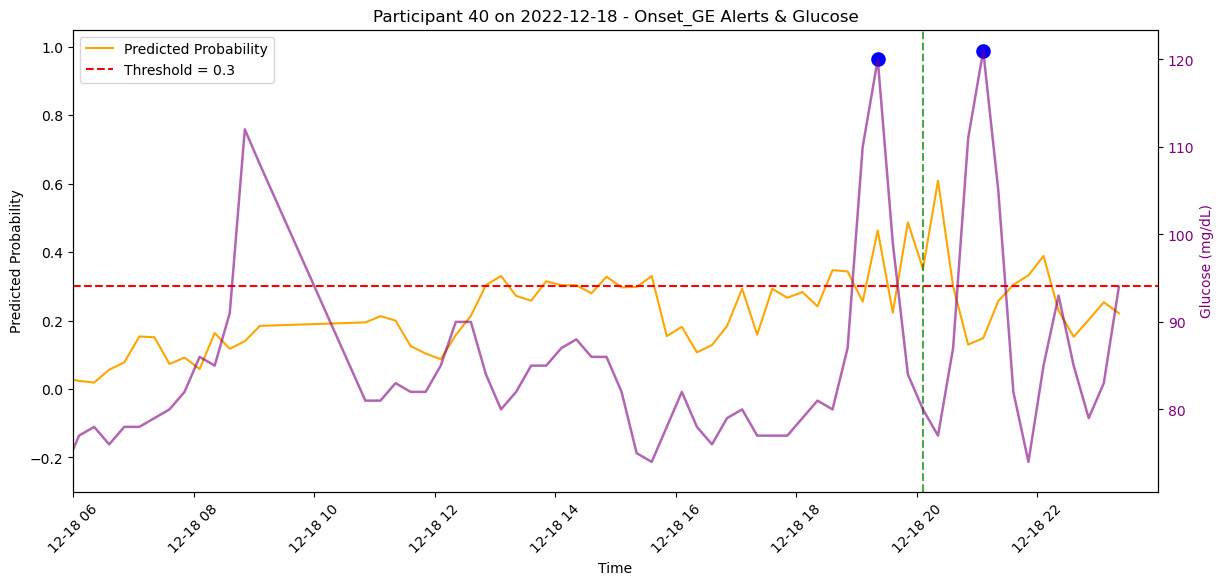

📋 Alert Summary:
           Alert_Time  Success     FP
0 2022-12-18 20:06:00     True  False

✅ Total Alerts: 1
🏆 Success (Onset_GE within 2hr): 1
❌ FP (Message Sent, No GE): 0


In [632]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 수정된 알림 시점 계산 함수 (조건 추가)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        hour = current_time.hour
        rolling_sum = df.loc[i, "Rolling_Sum"]
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# 시각화 및 결과 요약 함수
def plot_alerts_with_success_only(df, study_id, date, threshold=0.3, cooldown_minutes=120):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)

    # Glucose 값 보간
    onset_df["Glucose_At_Onset"] = np.interp(
        onset_df["Shifted_Timestamp"].astype(np.int64),
        sub_df["Timestamp"].astype(np.int64),
        sub_df["Glucose"]
    )

    results = []
    success_count = 0
    fp_count = 0
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    for alert_time in alert_times:
        has_success = any(alert_time <= t <= alert_time + timedelta(minutes=120) for t in shifted_onset_times)
        results.append({
            "Alert_Time": alert_time,
            "Success": has_success,
            "FP": not has_success
        })
        if has_success:
            success_count += 1
        else:
            fp_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

        ax2.scatter(
            onset_df["Shifted_Timestamp"],
            onset_df["Glucose_At_Onset"],
            color="blue",
            s=90,
            label="GE Onset (+1hr)"
        )

    plt.title(f"Participant {study_id} on {date} - Onset_GE Alerts & Glucose")
    plt.show()

    # 결과 요약 출력
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🏆 Success (Onset_GE within 2hr): {success_count}")
    print(f"❌ FP (Message Sent, No GE): {fp_count}")

# 실행 예시
participant_id = 40
specific_date = pd.to_datetime("2022-12-18").date()  # 원하는 날짜로 수정

plot_alerts_with_success_only(holdout_df, participant_id, specific_date, threshold=0.3)


# 8

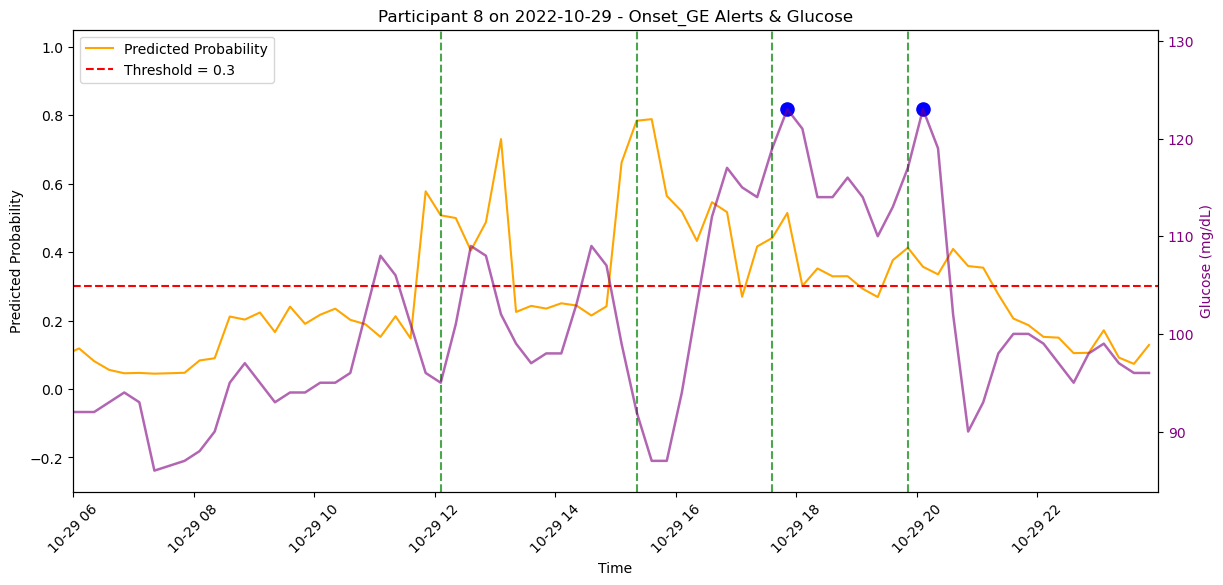

📋 Alert Summary:
           Alert_Time  Success     FP
0 2022-10-29 12:06:00    False   True
1 2022-10-29 15:21:00    False   True
2 2022-10-29 17:36:00     True  False
3 2022-10-29 19:51:00     True  False

✅ Total Alerts: 4
🏆 Success (Onset_GE within 2hr): 2
❌ FP (Message Sent, No GE): 2


In [652]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 날짜 컬럼 생성
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])
holdout_df["Date"] = holdout_df["Timestamp"].dt.date

# 수정된 알림 시점 계산 함수 (조건 추가)
def get_alert_times(df, threshold=0.3, cooldown_minutes=120):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    df["Above_Threshold"] = (df["Predicted_Proba"] >= threshold).astype(int)
    df["Rolling_Sum"] = df["Above_Threshold"].rolling(window=2, min_periods=2).sum()

    alert_times = []
    last_alert_time = pd.Timestamp.min

    for i in range(1, len(df)):
        current_time = df.loc[i, "Timestamp"]
        hour = current_time.hour
        rolling_sum = df.loc[i, "Rolling_Sum"]
        z_pre4 = df.loc[i, "Z_Previous_4"]
        pre4 = df.loc[i, "Previous_4_Glucose"]

        if (
            rolling_sum >= 2 and
            current_time >= last_alert_time + timedelta(minutes=cooldown_minutes) and
            8 <= hour < 22 and
            z_pre4 >= 0.1 and
            pre4 < 130
        ):
            alert_times.append(current_time)
            last_alert_time = current_time

    return alert_times

# 시각화 및 결과 요약 함수
def plot_alerts_with_success_only(df, study_id, date, threshold=0.3, cooldown_minutes=120):
    sub_df = df[(df["StudyID"] == study_id) & (df["Date"] == date)].sort_values("Timestamp").reset_index(drop=True)

    if sub_df.empty:
        print(f"⚠️ No data for participant {study_id} on {date}")
        return

    alert_times = get_alert_times(sub_df, threshold=threshold, cooldown_minutes=cooldown_minutes)
    onset_df = sub_df[sub_df["Onset_GE"] == 1].copy()
    onset_df["Shifted_Timestamp"] = onset_df["Timestamp"] + timedelta(minutes=60)

    # Glucose 값 보간
    onset_df["Glucose_At_Onset"] = np.interp(
        onset_df["Shifted_Timestamp"].astype(np.int64),
        sub_df["Timestamp"].astype(np.int64),
        sub_df["Glucose"]
    )

    results = []
    success_count = 0
    fp_count = 0
    shifted_onset_times = onset_df["Shifted_Timestamp"].tolist()

    for alert_time in alert_times:
        has_success = any(alert_time <= t <= alert_time + timedelta(minutes=120) for t in shifted_onset_times)
        results.append({
            "Alert_Time": alert_time,
            "Success": has_success,
            "FP": not has_success
        })
        if has_success:
            success_count += 1
        else:
            fp_count += 1

    # 시각화
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    ax1.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    for alert_time in alert_times:
        ax1.axvline(x=alert_time, color="green", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Predicted Probability")
    ax1.set_ylim(-0.3, 1.05)
    ax1.set_xlim(pd.Timestamp(f"{date} 06:00:00"), pd.Timestamp(f"{date} 23:59:59"))
    ax1.set_xlabel("Time")
    ax1.legend(loc="upper left")
    plt.xticks(rotation=45)

    if "Glucose" in sub_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(sub_df["Timestamp"], sub_df["Glucose"], label="Glucose", color="purple", linewidth=1.8, alpha=0.6)
        ax2.set_ylabel("Glucose (mg/dL)", color="purple")
        ax2.tick_params(axis="y", labelcolor="purple")

        ax2.scatter(
            onset_df["Shifted_Timestamp"],
            onset_df["Glucose_At_Onset"],
            color="blue",
            s=90,
            label="GE Onset (+1hr)"
        )

    plt.title(f"Participant {study_id} on {date} - Onset_GE Alerts & Glucose")
    plt.show()

    # 결과 요약 출력
    result_df = pd.DataFrame(results)
    print("📋 Alert Summary:")
    print(result_df)
    print(f"\n✅ Total Alerts: {len(alert_times)}")
    print(f"🏆 Success (Onset_GE within 2hr): {success_count}")
    print(f"❌ FP (Message Sent, No GE): {fp_count}")

# 실행 예시
participant_id = 8
specific_date = pd.to_datetime("2022-10-29").date()  # 원하는 날짜로 수정

plot_alerts_with_success_only(holdout_df, participant_id, specific_date, threshold=0.3)